In [2]:
from matplotlib        import collections             as matcoll
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy
from adjustText        import adjust_text
from sklearn.metrics import *

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys
import os

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

figure_path = main_path + '/workflow/figures/subtype/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
sys.path.append(main_path)
# from models.clustering.logistic_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()

### Settings

In [6]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
# meta_folder     = 'meso_overal_survival_nn400'

matching_field  = 'slides'
meta_field      = 'Meso_type'


# Penalties for Cox regression and flag for usage.
use_cox        = False
alpha          = 5.0

# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)

# adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, '750K', groupby, fold_number)




### Training and Evaluation Part

Analysis results on best alpha and resolution (alpha:5, res:5)

In [3]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve
def get_scores_simple(labels, y_prob):
    scores = dict()
    labels = np.array(labels)
    y_prob = np.array(y_prob)
    scores['ROC AUC'] = roc_auc_score(y_true=list(labels), y_score=list(y_prob))
    scores['Avg. Precision'] = average_precision_score(y_true=list(labels), y_score=list(y_prob))
    # scores['accuracy_score'] = accuracy_score(y_true=list(labels), y_pred=(y_prob>0.5)*1.0)
    # scores['f1_score'] = f1_score(y_true=list(labels), y_pred=(y_prob>0.5)*1.0)
    # scores['recall_score'] = recall_score(y_true=list(labels), y_pred=(y_prob>0.5)*1.0)
    tn, fp, fn, tp = confusion_matrix(labels, (y_prob>0.5)*1.0).ravel()
    scores['Sensitivity'] = tp / (tp+fn)
    scores['Specificity'] = tn / (tn+fp)
    # scores['precision_score'] = precision_score(y_true=list(labels), y_pred=(y_prob>0.5)*1.0)
    return scores

In [4]:
import statsmodels.api as sm


# Get AUC performance.
def get_scores(model, data, label, mode):
	threshold = 0.3
	train, valid, test, additional = data
	train_data, train_labels = train
	if valid is not None:
		valid_data, valid_labels = valid
	test_data,  test_labels  = test
	if additional is not None:
		additional_data, additional_labels = additional

	# Predictions.
	train_pred = model.predict(exog=train_data)
	if valid is not None:
		valid_pred = model.predict(exog=valid_data)
	test_pred  = model.predict(exog=test_data)
	if additional is not None:
		additional_pred = model.predict(exog=additional_data)
	tn, fp, fn, tp = confusion_matrix(train_labels[:,label], (train_pred > threshold)*1.0).ravel()
	if mode == 'AUC': 					train_auc = roc_auc_score(y_true=list(train_labels[:,label]), y_score=list(train_pred))
	elif mode == 'Average Precision': 	train_auc = average_precision_score(y_true=list(train_labels[:,label]), y_score=list(train_pred))
	elif mode == 'Accuracy': 			train_auc = accuracy_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'F1 Score': 			train_auc = f1_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'Recall Score': 		train_auc = recall_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'Precision Score': 	train_auc = precision_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'Sensitivity': 		train_auc = tp / (tp+fn)
	elif mode == 'Specificity': 		train_auc  = tn / (tn+fp)
	else: raise ValueError('Mode not recognized.')	
	

	aucs = [train_auc]
	# aucs = []
	valid_auc = None
	if valid is not None:
		tn, fp, fn, tp = confusion_matrix(valid_labels[:,label], (valid_pred > threshold)*1.0).ravel()
		# valid_auc = roc_auc_score(y_true=list(valid_labels[:,label]), y_score=list(valid_pred))
		if mode == 'AUC': 					valid_auc = roc_auc_score(y_true=list(valid_labels[:,label]), y_score=list(valid_pred))
		elif mode == 'Average Precision': 	valid_auc = average_precision_score(y_true=list(valid_labels[:,label]), y_score=list(valid_pred))
		elif mode == 'Accuracy': 			valid_auc = accuracy_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'F1 Score': 			valid_auc = f1_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'Recall Score': 		valid_auc = recall_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'Precision Score': 	valid_auc = precision_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'Sensitivity': 		valid_auc = tp / (tp+fn)
		elif mode == 'Specificity': 		valid_auc  = tn / (tn+fp)
		else: raise ValueError('Mode not recognized.')
		aucs.append(valid_auc)
	tn, fp, fn, tp = confusion_matrix(test_labels[:,label], (test_pred > threshold)*1.0).ravel()
	# test_auc  = roc_auc_score(y_true=list(test_labels[:,label]),  y_score=list(test_pred))
	if mode == 'AUC': 					test_auc = roc_auc_score(y_true=list(test_labels[:,label]), y_score=list(test_pred))
	elif mode == 'Average Precision': 	test_auc = average_precision_score(y_true=list(test_labels[:,label]), y_score=list(test_pred))
	elif mode == 'Accuracy': 			test_auc = accuracy_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'F1 Score': 			test_auc = f1_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'Recall Score': 		test_auc = recall_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'Precision Score': 	test_auc = precision_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'Sensitivity': 		test_auc = tp / (tp+fn)
	elif mode == 'Specificity': 		test_auc  = tn / (tn+fp)
	else: raise ValueError('Mode not recognized.')

	aucs.append(test_auc)
	additional_auc = None
	if additional is not None:
		tn, fp, fn, tp = confusion_matrix(additional_labels[:,label], (additional_pred > threshold)*1.0).ravel()
		additional_pred = model.predict(exog=additional_data)
		if mode == 'AUC': 					additional_auc = roc_auc_score(y_true=list(additional_labels[:,label]), y_score=list(additional_pred))
		elif mode == 'Average Precision': 	additional_auc = average_precision_score(y_true=list(additional_labels[:,label]), y_score=list(additional_pred))
		elif mode == 'Accuracy': 			additional_auc = accuracy_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'F1 Score': 			additional_auc = f1_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'Recall Score': 		additional_auc = recall_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'Precision Score': 	additional_auc = precision_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'Sensitivity': 		additional_auc = tp / (tp+fn)
		elif mode == 'Specificity': 		additional_auc  = tn / (tn+fp)
		else: raise ValueError('Mode not recognized.')
		aucs.append(additional_auc)
	return aucs

# Include coefficients into clusters dataframe.
def include_coefficients(model, frame_clusters_orig, features, label, groupby):
	frame_clusters = frame_clusters_orig.copy(True)

	# Include model coef.
	results_summary = model.summary()
	results_as_html = results_summary.tables[1].as_html()
	results_df      = pd.read_html(results_as_html, header=0, index_col=0)[0]

	for column in ['coef', 'P>|z|','[0.025','0.975]']:
		frame_clusters['%s_%s' % (column, label)] = [np.inf]*frame_clusters.shape[0]
		for i, cluster_id in enumerate(features):
			frame_clusters.loc[frame_clusters[groupby]==int(cluster_id), '%s_%s' % (column, label)] = float(results_df.loc[int(i), column])
	return frame_clusters


# Build confusion matrices.
def get_confusion_matrix(model, data, label):
	train, valid, test, additional = data
	test_data,  test_labels  = test
	if additional is not None:
		additional_data, additional_labels = additional

	test_pred  = model.predict(exog=test_data)
	if additional is not None:
		additional_pred = model.predict(exog=additional_data)

	test_labels = test_labels[:,label]
	test_pred   = (test_pred > 0.5)*1.0

	cm_test = confusion_matrix(test_labels, test_pred)
	cm_additional = None
	if additional is not None:
		additional_labels = additional_labels[:,label]
		additional_pred   = (additional_pred > 0.5)*1.0
		cm_additional = confusion_matrix(additional_labels, additional_pred)
	return [cm_test, cm_additional]


# Fit logistic regression and check performance.
def classification_performance_stats(data, leiden_clusters, frame_clusters, features, groupby, alpha, modes=['auc', 'ap']):
	train, valid, test, additional = data
	train_data, train_labels = train

	# Train classifier
	labels = np.unique(np.argmax(train_labels, axis=1)).tolist()
	if len(labels) == 2:
		labels.remove(0)

	# One-vs-rest for Logistic Regression.
	num_sets = len([1 for set in data if set is not None])
	shape_aucs = (len(labels), len(modes), num_sets)
	total_aucs = np.zeros(shape_aucs)
	cms        = dict()
	for label in labels:
		model                  = sm.Logit(endog=train_labels[:,label], exog=train_data).fit_regularized(method='l1_cvxopt_cp',alpha=alpha, maxiter=1000, disp=False)
		# total_aucs[label-1,:]  = get_avg_precision(model, data, label)
		# total_aucs[label-1,:]  = get_aucs(model, data, label)
		for mode in modes:
			total_aucs[label-1, modes.index(mode), :]  = get_scores(model, data, label, mode)


		# total_aucs[label-1,:, :]  = get_scores_simple(train_labels[:,label], model.predict(exog=train_data))
			
		# Include information in Clusters DataFrame.
		frame_clusters = include_coefficients(model, frame_clusters, features, label, groupby)

		# Confusion matrices.
		label_cms = get_confusion_matrix(model, data, label)
		cms[label] = label_cms

	aucs = total_aucs.mean(axis=0).tolist()
	return frame_clusters, aucs, cms, model


def roc_curve_plot(pred, labels, title, label):
	sns.set(style='white', font_scale=1)
	fpr, tpr, thresholds = roc_curve(labels, pred)
	fig, ax = plt.subplots(figsize=(4.5,4.5))
	ax.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
	ax.set_xlim([0.0, 1.0])
	ax.set_ylim([0.0, 1.0])
	ax.set_xlabel('False Positive Rate')
	ax.set_ylabel('True Positive Rate')
	ax.set_title(title)
	# set font size
	plt.rcParams.update({'font.size': 12})



	# Plot ROC curve.
	ax.plot(fpr, tpr, label=label)
	plt.legend(loc="lower right")
	# plt.show()
	return ax



Subsampling: undersampling ___________________________________________


Leiden Resolution    Train AUC     Test AUC Additional AUC   
0               2.0  91.4 ± 0.01  88.4 ± 0.04    80.3 ± 0.03  \

  Train Recall Score Test Recall Score Additional Recall Score   
0        84.9 ± 0.03        80.8 ± 0.1             62.9 ± 0.06  \

  Train Precision Score Test Precision Score Additional Precision Score  ...   
0           68.4 ± 0.03          61.2 ± 0.21                69.0 ± 0.05  ...  \

  Additional F1 Score Train Accuracy Test Accuracy Additional Accuracy   
0         65.6 ± 0.04    82.5 ± 0.02   77.0 ± 0.07         72.4 ± 0.02  \

  Train Sensitivity Test Sensitivity Additional Sensitivity Train Specificity   
0       84.9 ± 0.03       80.8 ± 0.1            62.9 ± 0.06       81.2 ± 0.03  \

  Test Specificity Additional Specificity  
0      76.5 ± 0.09            79.4 ± 0.04  

[1 rows x 22 columns]

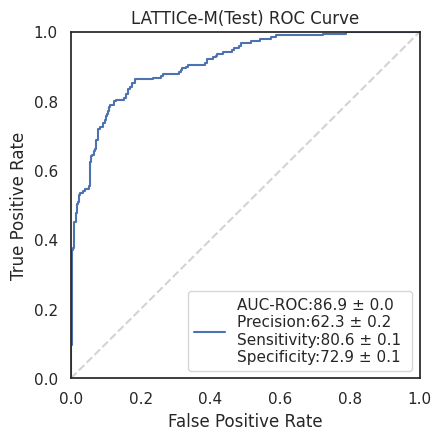

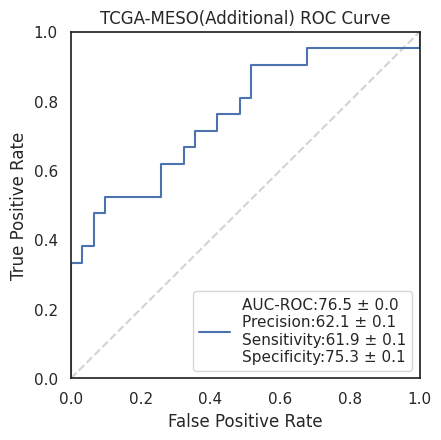

In [7]:
folds = load_existing_split(folds_pickle)
subtype_csvs_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/subtype_csvs'.format(main_path, dataset, meta_folder)
frame_clusters = dict()
models = dict()
subsampling = True
type_composition = 'clr'
score_modes = ['AUC', 'Recall Score', 'Precision Score', 'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity']
# score_modes = ['Precision Score', 'Sensitivity', 'Specificity']
all_aucs = []
# resolutions = ['2p0', '0p7', '1p0', '1p5', '2p5', '3p0', '4p0', '5p0', '7p0', '9p0']
# resolutions = ['2p0', '4p0', '7p0', '9p0']
resolutions = ['2p0']

# for subsampling in [None,'oversampling', 'undersampling']:
for subsampling in ['undersampling']:
    print('Subsampling:', subsampling, '___________________________________________')
    for resolution in resolutions:
        frame_clusters[resolution] = dict()
        models[resolution] = dict()
        for fold in range(5):
            # fold = 4
            df_all = pd.read_csv('{}/{}_{}_leiden_{}_fold{}.csv'.format(subtype_csvs_path, dataset, type_composition, resolution, fold), index_col=0)
            df_all.drop('Meso_type_x', axis=1, inplace=True)
            df_all.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)

            train_samples = folds[fold][0]
            val_samples = folds[fold][1]
            test_samples = folds[fold][2]
            train_df = df_all[df_all['samples'].isin(train_samples)]
            test_df = df_all[df_all['samples'].isin(test_samples)]

            additional_df = pd.read_csv('{}/{}_{}_leiden_{}_fold{}_additional.csv'.format(subtype_csvs_path, additional_dataset, type_composition, resolution, fold), index_col=0)
            additional_df.drop('Meso_type_x', axis=1, inplace=True)
            additional_df.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)

            # Include features that are not the regular leiden clusters.
            frame_cluster = pd.read_csv('{}/HPC_frames/{}_{}_leiden_{}_fold{}_hpc_purity.csv'.format(subtype_csvs_path, dataset, type_composition, resolution, fold), index_col=0)



            features = [x for x in df_all.columns.tolist() if x.isdigit()]
            leiden_clusters = [int(x) for x in features]
            train_labels = np.array(train_df[['Meso_type']].values.astype(int).tolist())
            train_labels = OneHotEncoder().fit_transform(train_labels.reshape(-1,1)).toarray()
            test_labels = np.array(test_df[['Meso_type']].values.astype(int).tolist())
            test_labels = OneHotEncoder().fit_transform(test_labels.reshape(-1,1)).toarray()
            additional_labels = np.array(additional_df[['Meso_type']].values.astype(int).tolist())
            additional_labels = OneHotEncoder().fit_transform(additional_labels.reshape(-1,1)).toarray()

            data = [[train_df[features], train_labels], None, [test_df[features], test_labels], [additional_df[features], additional_labels]]
            if subsampling is not None:
                # Subsampling the imbalance data
                from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE # SMOTE
                from imblearn.combine import SMOTEENN, SMOTETomek # SMOTETomek
                from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler
                if subsampling == 'undersampling':
                    smt = EditedNearestNeighbours() #undersampling
                elif subsampling == 'oversampling':
                    smt = SMOTETomek(random_state=42) #oversampling
                else:
                    smt = None
                    raise ValueError('Subsampling method not recognized.')
                
                for df in data:
                    if df is not None:
                        df[0], df[1] = smt.fit_resample(df[0], df[1])
                        df[1] = OneHotEncoder().fit_transform(df[1].reshape(-1, 1)).toarray()
            
            frame_cluster, aucs, cms, lr_model = classification_performance_stats(data, leiden_clusters, frame_cluster, features, 'leiden_{}'.format(resolution.replace('p','.')), alpha=5, modes=score_modes)


            # if fold == 0: draw the roc curve for additional data and test data
            if fold == 4:
                test_labels = data[2][1][:,1]
                test_pred = lr_model.predict(exog=data[2][0])

                additional_labels = data[3][1][:,1]
                additional_pred = lr_model.predict(exog=data[3][0])
                
            frame_clusters[resolution][fold] = frame_cluster
            models[resolution][fold] = lr_model

            # print('\t\t\tFold %s %-3s features Train/Test/Additional Score:' % (fold, len(features)), np.round(aucs,2))

            # Report forest plots and confusion matrices for logistic regression.
            # from models.visualization.forest_plots import report_forest_plot_lr
            alpha_path = os.path.join(subtype_csvs_path.split('/subtype_csvs')[0], 'alpha_{}'.format(alpha))
            if not os.path.exists(alpha_path):
                os.makedirs(alpha_path)
            # report_forest_plot_lr(meta_field, frame_cluster, directory=alpha_path, file_name='%s_fold%s_clusters.csv' % (resolution, fold))
            mode_auc = []
            for auc in aucs: mode_auc += auc
            all_aucs.append([resolution.replace('p','.'), fold] + mode_auc)

    # Save to CSV.
    mode_sets = []
    for mode in score_modes: 
        mode_sets += ['Train {}'.format(mode), 'Test {}'.format(mode), 'Additional {}'.format(mode)]

    columns = ['Leiden Resolution', 'Fold']+ mode_sets
    results_df = pd.DataFrame(all_aucs, columns=columns)
    # results_df.to_csv(os.path.join(alpha_path, '%s_recall_results.csv' % (meta_field)), index=False)

    # Performance figures.
    # from models.clustering.logistic_regression_leiden_clusters import box_plot_auc_results
    # box_plot_auc_results(frame=results_df, columns=columns, path_file=os.path.join(alpha_path, '%s_recall_results.csv' % (meta_field)))

    df_mean = results_df.groupby(['Leiden Resolution']).mean().drop('Fold', axis=1).apply(lambda x: np.round(x*100,1))
    df_std = results_df.groupby(['Leiden Resolution']).std().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
    temp = (df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()


    label_test = 'AUC-ROC:86.9 ± 0.0\nPrecision:62.3 ± 0.2  \nSensitivity:80.6 ± 0.1 \nSpecificity:72.9 ± 0.1'
    roc_curve_plot(test_pred, test_labels, 'LATTICe-M(Test) ROC Curve', label=label_test)

    label_additional = 'AUC-ROC:76.5 ± 0.0\nPrecision:62.1 ± 0.1  \nSensitivity:61.9 ± 0.1\nSpecificity:75.3 ± 0.1'
    roc_curve_plot(additional_pred, additional_labels, 'TCGA-MESO(Additional) ROC Curve', label=label_additional)

    # Save to CSV.
    # temp.to_csv(os.path.join(figure_path, '%s_subtype_scores_%s.csv' % (meta_field, str(subsampling))), index=True)
    display(temp)
        


### MesoGraph Data

In [ ]:
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

import sys
sys.path.append(main_path)
# from models.clustering.logistic_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()

In [ ]:
import torch

import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np

class CsvBags(torch.utils.data.Dataset):
    def __init__(self, csv):
        self.csv = csv
        self.bags, self.labels = self._create_bag()


    def __len__(self):
        return len(self.bags)

    def _create_bag(self):
        bag_list = []
        label_list = []
        for bag in self.csv['slides'].unique():

            bag_df = self.csv[self.csv['slides']==bag]
            bag_list.append(torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1))
            label_list.append(torch.from_numpy(bag_df['Meso_type'].values))
        return bag_list, label_list

    def __getitem__(self, idx):
        return self.bags[idx], self.labels[idx]


In [ ]:
def make_weighted_loder(data):
    from torch.utils.data import WeightedRandomSampler
    all_labels = torch.tensor([t[0].item() for t in CsvBags(data).labels], dtype=torch.long)
    class_counts = torch.bincount(all_labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[all_labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = torch.utils.data.DataLoader(CsvBags(data), batch_size=1, sampler=sampler)
    return loader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Attention MIL
class AttentionMIL(nn.Module):
    def __init__(self, hidden_dim, att_dim):
        super(AttentionMIL, self).__init__()
        self.hidden_dim = hidden_dim
        self.att_dim = att_dim
        self.K = 1 # dimension of the attention vector

        
        # Attention Mechanism for scoring instances
        self.attention = nn.Sequential(
            nn.Linear(self.hidden_dim, self.att_dim),
            nn.Tanh(),
            nn.Linear(self.att_dim, self.K)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)
        x = x.squeeze(1)
        # attention scores
        A = self.attention(x)
        A = A.transpose(1, 0)
        A = F.softmax(A, dim=1)
        # weighted instances
        C = torch.mm(A, x)
        
        # classification
        Y_prob = self.classifier(C)
        Y_hat = torch.ge(Y_prob, 0.5).float()
        return Y_prob, Y_hat, A, C
        

In [ ]:
from torch import nn
import torch
import torch.nn.functional as F

class GatedAttention(nn.Module):
    def __init__(self, input_dim, att_dim):
        super(GatedAttention, self).__init__()
        self.M = input_dim
        self.L = att_dim
        self.ATTENTION_BRANCHES = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid()
        )

        self.attention_w = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = nn.Sequential(
            nn.Linear(self.M*self.ATTENTION_BRANCHES, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)
        x = x.squeeze(1)

        A_V = self.attention_V(x)  # KxL
        A_U = self.attention_U(x)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.transpose(A, 1, 0)  # ATTENTION_BRANCHESxK
        A = F.softmax(A, dim=1)  # softmax over K

        Z = torch.mm(A, x)  # ATTENTION_BRANCHESxM

        Y_prob = self.classifier(Z)
        Y_hat = torch.ge(Y_prob, 0.4).float()

        return Y_prob, Y_hat, A, Z


In [ ]:
dataset = 'Meso'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')


csv_data = frame.iloc[:,0:128]
csv_data['Meso_type'] = frame['Meso_type'].astype(float)
csv_data['slides'] = frame['slides']
ratio = 0.8
train_df_slides = csv_data['slides'].unique()[:int(ratio*len(csv_data['slides'].unique()))]
test_df_slides = csv_data['slides'].unique()[int(ratio*len(csv_data['slides'].unique())):]
train_df = csv_data[csv_data['slides'].isin(train_df_slides)]
test_df = csv_data[csv_data['slides'].isin(test_df_slides)]

# takes time :(
# train_loader = torch.utils.data.DataLoader(CsvBags(train_df), batch_size=1, shuffle=True)
# test_loader = torch.utils.data.DataLoader(CsvBags(test_df), batch_size=1, shuffle=True)
train_loader = make_weighted_loder(train_df)
test_loader = make_weighted_loder(test_df)

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/hdf5_Meso_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['HB_score', 'Meso_type', 'N_stage', 'Sex', 'TNM_Stage', 'T_Stage', 'age', 'case_Id', 'chest_wall_involvement', 'confident_diagnosis', 'desmoplastic_component', 'diaphragm_involvement', 'haemoglobin', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'lung_involvement', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'recurrence', 'rib_involvement', 'samples', 'side', 'slides', 'smoking_history', 'tiles', 'time_to_recurrence', 'type', 'wcc_score']>


In [ ]:
# Main dataset

input_dim = 128  # Dimension of each instance's feature vector
hidden_dim = 64  # Dimension of the hidden layer
# model = AttentionMIL(input_dim, hidden_dim)
model = GatedAttention(input_dim, hidden_dim)
# Training settings
learning_rate = 0.001
num_epochs = 6
scores = pd.DataFrame()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    train_error = 0.

    predictions, probs = [], []
    labels = []
    for instances, label in train_loader:
        instances = Variable(instances.float())
        label = label.T[0]
        label = Variable(label.float())
        optimizer.zero_grad()
        y_prob, y_hat, attention_score, weighted_instances = model(instances)

        error = 1. - y_hat.eq(label.float()).cpu().float().mean()
        train_error += error.item()

        y_prob = torch.clamp(y_prob, min=1e-5, max=1. - 1e-5)
        loss = - (label * torch.log(y_prob) + (1. - label) * torch.log(1. - y_prob))
        # loss = loss.mean()
        train_loss += loss.item()

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.item())

        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    train_error /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}, Error: {:.5f}'.format(epoch, train_loss, train_error))
    # get_scores_simple(labels, probs)

    # Test loop
    model.eval()
    predictions, probs = [], []
    labels = []
    for instances, label in test_loader:
        instances = Variable(instances.float())
        label = label.T[0]
        label = Variable(label.float())
        y_prob, y_hat, attention_score, weighted_instances = model(instances)

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.item())

    print('Test Set, Accuracy: {:.4f}%'.format(accuracy_score(labels, predictions)*100))
    get_scores_simple(labels, probs)
    print('-----------------------------------------------------------------------------')

    scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
    scores = pd.concat([scores, scr_dict], ignore_index=True)

# Save the model
from copy import deepcopy
model_trained = deepcopy(model)


print(scores)
df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

Train Set, Epoch: 0, Loss: 0.46800, Error: 0.24492
Test Set, Accuracy: 73.9130%
-----------------------------------------------------------------------------
Train Set, Epoch: 1, Loss: 0.39702, Error: 0.19920
Test Set, Accuracy: 81.5942%
-----------------------------------------------------------------------------
Train Set, Epoch: 2, Loss: 0.37749, Error: 0.18106
Test Set, Accuracy: 81.0145%
-----------------------------------------------------------------------------
Train Set, Epoch: 3, Loss: 0.36864, Error: 0.17126
Test Set, Accuracy: 81.3043%
-----------------------------------------------------------------------------
Train Set, Epoch: 4, Loss: 0.34294, Error: 0.16292
Test Set, Accuracy: 80.2899%
-----------------------------------------------------------------------------
Train Set, Epoch: 5, Loss: 0.35170, Error: 0.15421
Test Set, Accuracy: 77.8261%
-----------------------------------------------------------------------------
    ROC AUC  Avg. Precision  Sensitivity  Specificit

index            0
0         ROC AUC  0.89 ± 0.02
1  Avg. Precision   0.9 ± 0.02
2     Sensitivity  0.82 ± 0.04
3     Specificity  0.76 ± 0.07

In [ ]:
# Just testing on additional dataset (TCGA_MESO)
additional_dataset = 'TCGA_MESO'
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
frame_additional, dims_additional, rest_additional = representations_to_frame(h5_additional_path, meta_field='Meso_type', rep_key='z_latent')
csv_data_additional = frame_additional.iloc[:,0:128]
csv_data_additional['Meso_type'] = frame_additional['type']
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}).astype(float)
csv_data_additional['slides'] = frame_additional['slides']


csv_loader_additional = make_weighted_loder(csv_data_additional)
model_trained.eval()
predictions, probs = [], []
labels = []
for instances, label in csv_loader_additional:
    instances = Variable(instances.float())
    label = label.T[0]
    label = Variable(label.float())
    y_prob, y_hat, attention_score, weighted_instances = model_trained(instances)

    predictions.append(int(y_hat))
    labels.append(int(label))
    probs.append(y_prob.item())

print('Additional Set, Accuracy: {:.4f}%'.format(accuracy_score(labels, predictions)*100))
print(get_scores_simple(labels, probs))
print('-----------------------------------------------------------------------------')

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/TCGA_MESO/h224_w224_n3_zdim128/hdf5_TCGA_MESO_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['Meso_type', 'age_at_diagnosis', 'age_at_index', 'ajcc_pathologic_m', 'ajcc_staging_system_edition', 'case_Id', 'days_to_birth', 'days_to_last_follow_up', 'ethnicity', 'gender', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'morphology', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'prior_malignancy', 'prior_treatment', 'race', 'samples', 'slides', 'stage', 'tiles', 'type', 'vital_status', 'year_of_birth', 'year_of_death', 'year_of_diagnosis']>
Additional Set, Accuracy: 80.2326%
{'ROC AUC': 0.8375, 'Avg. Precision': 0.863709333617263, 'Sensitivity': 0.5, 'Specificity': 0.9565217391304348}
-----------------------------------------------------------------------------


In [ ]:
######## Make dataframe ready for the model
additional_dataset = 'MesoGraph' # or 'TCGA_MESO'
additional_h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
additional_frame, additional_dims, additional_rest = representations_to_frame(additional_h5_complete_path, meta_field='Meso_type', rep_key='z_latent')

csv_data_additional = additional_frame.drop(['hist_subtype', 'indexes', 'labels', 'original_set', 'patterns', 'samples', 'tiles'], axis=1)
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].apply(lambda x: 0 if x == 'E' else 1)
######### make 5 folds of data
test_slide_list = np.array_split(csv_data_additional['slides'].unique(), 5)
train_slide_list = [np.setdiff1d(csv_data_additional['slides'].unique(), test_slide_list[i]) for i in range(5)]

######## put 1-ratio of the data to the test set
# ratio = 0.7
# csv_data_additional = csv_data_additional.sample(frac=1).reset_index(drop=True)
# train_df_slides_additional = csv_data_additional['slides'].unique()[:int(ratio*len(csv_data_additional['slides'].unique()))]
# test_df_slides_additional = csv_data_additional['slides'].unique()[int(ratio*len(csv_data_additional['slides'].unique())):]
# test_df_additional = csv_data_additional[csv_data_additional['slides'].isin(test_df_slides_additional)]



# set random seed
torch.manual_seed(0)
np.random.seed(0)

input_dim = 128  # Dimension of each instance's feature vector
hidden_dim = 64  # Dimension of the hidden layer
# model = AttentionMIL(input_dim, hidden_dim)
model_ = GatedAttention(input_dim, hidden_dim)
# Training settings
learning_rate = 0.001
num_epochs = 6
scores = pd.DataFrame()
optimizer = optim.Adam(model_.parameters(), lr=learning_rate)


# Training loop
for fold_number in range(5):
    train_df_additional = csv_data_additional[csv_data_additional['slides'].isin(train_slide_list[fold_number])]
    train_loader_additional = make_weighted_loder(train_df_additional)
    test_df_additional = csv_data_additional[csv_data_additional['slides'].isin(test_slide_list[fold_number])]
    test_loader_additional = make_weighted_loder(test_df_additional)
    
    for epoch in range(num_epochs):
        model_.train()
        train_loss = 0.
        train_error = 0.

        predictions, probs = [], []
        labels = []
        for instances, label in train_loader_additional:
            instances = Variable(instances.float())
            label = label.T[0]
            label = Variable(label.float())
            optimizer.zero_grad()
            y_prob, y_hat, attention_score, weighted_instances = model_(instances)

            error = 1. - y_hat.eq(label.float()).cpu().float().mean()
            train_error += error.item()

            y_prob = torch.clamp(y_prob, min=1e-5, max=1. - 1e-5)
            loss = - (label * torch.log(y_prob) + (1. - label) * torch.log(1. - y_prob))
            train_loss += loss.item()

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())

            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader_additional)
        train_error /= len(train_loader_additional)
        # print('Train Set, Epoch: {}, Loss: {:.5f}, Error: {:.5f}'.format(epoch, train_loss, train_error))
        # Test loop
        model_.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in test_loader_additional:
            instances = Variable(instances.float())
            label = label.T[0]
            label = Variable(label.float())
            y_prob, y_hat, attention_score, weighted_instances = model_(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())

        # print('Test Set, Epoch:{}, Accuracy: {:.4f}%'.format(epoch, accuracy_score(labels, predictions)*100))
        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)


df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()
# scores.plot()

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/MesoGraph/h224_w224_n3_zdim128/hdf5_MesoGraph_he_complete_metadata.h5
Keys: <KeysViewHDF5 ['Meso_type', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'original_set', 'patterns', 'samples', 'slides', 'tiles']>


index            0
0         ROC AUC  0.93 ± 0.12
1  Avg. Precision  0.93 ± 0.12
2     Sensitivity  0.94 ± 0.09
3     Specificity  0.86 ± 0.19

### Forest Plot

In [45]:
annot_flag = True


#  resoltuion 2.0 and Fold 4
model = models['2p0'][4]
results = model.summary().tables[1]
results_df = pd.read_html(results.as_html(), header=0, index_col=0)[0]
results_df['hpc'] = results_df.index
results_df = results_df.sort_values(by='coef', ascending=False).reset_index(drop=True)


significance = 0.05
results_df_signfcnt = results_df[results_df['P>|z|'] < significance]
epith_clusters = results_df_signfcnt[results_df_signfcnt['coef'] < 0].sort_values(by='coef', ascending=True)
sarc_clusters = results_df_signfcnt[results_df_signfcnt['coef'] > 0].sort_values(by='coef', ascending=False)




# export needed tiles
im_list_dict = dict()
for class_ in ['epithelioid', 'sarcomatoid']:
    im_list = []
    if class_ == 'epithelioid': cluster_set = epith_clusters.hpc.astype('str')
    elif class_ == 'sarcomatoid': cluster_set = sarc_clusters.hpc.astype('str')
    for cluster_number in cluster_set:
        indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
        i_rand = np.random.randint(0, len(indexes))
        index_ = indexes[i_rand]
        set_ = sets[i_rand]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
        h5_image.close()
    im_list_dict[class_] = im_list

# showing the tiles
# import matplotlib.pyplot as plt
# import numpy as np
# import random

# fig, axs = plt.subplots(2, 10, figsize=(20, 10))
# for i, class_ in enumerate(im_list_dict.keys()):
#     for j, (im, cluster_number) in enumerate(im_list_dict[class_]):
#         axs[i,j].imshow(im)
#         axs[i,j].set_title('Cluster: {}'.format(cluster_number))
#         axs[i,j].axis('off')

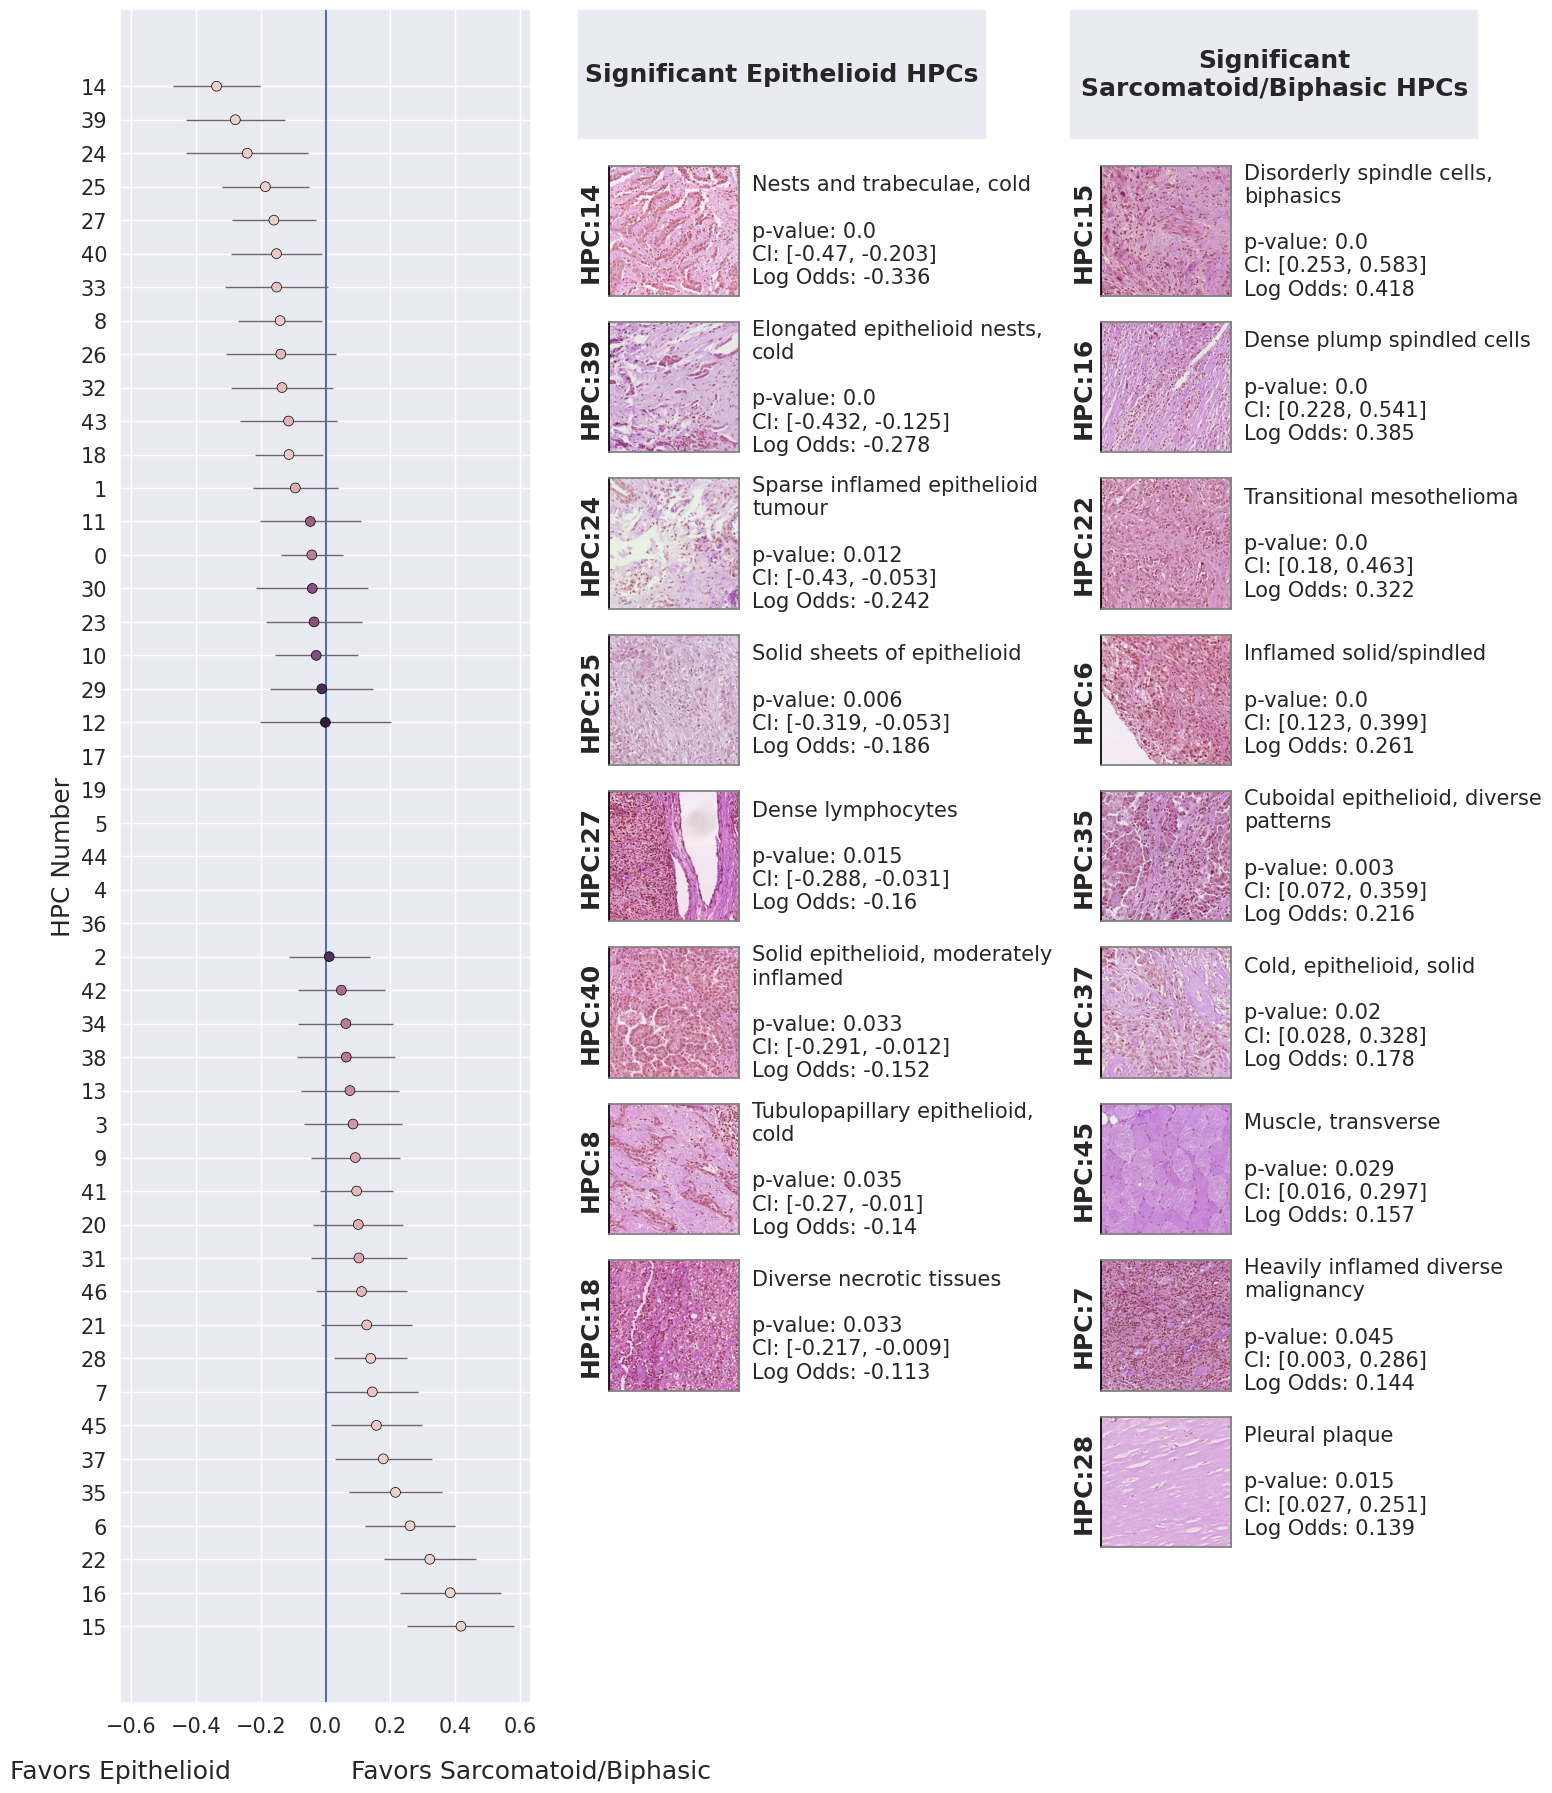

In [48]:
import textwrap
sns.set_style("darkgrid")

#  Forest Plot
center = 0.0
effect_measure = results_df['coef'].values.astype(str).astype(float)
lower = results_df['[0.025'].values
upper = results_df['0.975]'].values
diff_upper = upper - effect_measure
diff_lower = effect_measure - lower

ncol, nrow = 3, 11
fig = plt.figure(figsize=(6*ncol, 2*nrow))
gs = fig.add_gridspec(nrow, ncol)
ax1 = fig.add_subplot(gs[:, 0])


fontsize = 18
plot = sns.scatterplot(data=results_df, x='coef', y=results_df.index, hue='P>|z|', sizes=(20, 200), legend=False, zorder=3, edgecolor='black', linewidth=0.5, s=50, ax=ax1)
plot.set_yticklabels(results_df['hpc'])
plot.set_yticks(results_df.index)
for tick in plot.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in plot.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plot.axvline(center, zorder=1)
plot.errorbar(effect_measure, results_df.index, xerr=[diff_upper, diff_lower], marker='None',zorder=2, ecolor='dimgrey', elinewidth=1, linewidth=0)

plot.set_xlabel('', fontsize=fontsize)
plot.set_ylabel('HPC Number', fontsize=fontsize)
max_value = max(abs(max(upper)), abs(min(lower)))
plot.set_xlim([-max_value-.05, max_value+.05])
plot.text(0.0, -.04, textwrap.fill('Favors Epithelioid',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize)
plot.text(1.0, -.04, textwrap.fill('Favors Sarcomatoid/Biphasic',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize);
################################################################################################################################ 



# Legends
for class_ in ['epithelioid', 'sarcomatoid']:
    im_list = im_list_dict[class_]
    if class_=='epithelioid': 
        i, j = 0, 1
        title = 'Significant Epithelioid HPCs'
    else: 
        i, j = 0, 2
        title = 'Significant Sarcomatoid/Biphasic HPCs'
    ax = fig.add_subplot(gs[i,j])
    ax.set(xticks=[], yticks=[])
    ax.text(0.5, 0.5, textwrap.fill(title, 30), fontsize=18, ha='center', va='center', weight='bold')
    pos = ax.get_position()
    ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
    i+=1

    for (image, cluster_number) in im_list:
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(image)
        ax.set(xticks=[], yticks=[])
        # ax.set_title('Cluster {}'.format(cluster_number), fontsize=fontsize)
        i += 1

        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=18))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])

        p_value = results_df[results_df['hpc']==int(cluster_number)]['P>|z|'].values[0]
        log_odds = results_df[results_df['hpc']==int(cluster_number)]['coef'].values[0]
        CI = [results_df[results_df['hpc']==int(cluster_number)]['[0.025'].values[0], results_df[results_df['hpc']==int(cluster_number)]['0.975]'].values[0]]
        if annot_flag: annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
        else: annotation_text = ''
        label_text = annotation_text + '\n \n'+ 'p-value: {}'.format(np.round(p_value, 3)) + '\n' + 'CI: [{}, {}]'.format(np.round(CI[0], 3), np.round(CI[1], 3)) + '\n' + 'Log Odds: {}'.format(np.round(log_odds, 3))
        
        ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="15", )

plt.savefig(os.path.join(figure_path,'forest_plot_subtype_annotated.png'), dpi=500, bbox_inches='tight')

In [49]:
h5_path_adata = h5_complete_path
groupby = 'leiden_2.0'
meta_folder_adata = '750K'
fold_number = 4
if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))


# Adding LogReg info to adata. (res2 and fold4)
temp = frame_clusters['2p0'][4][['leiden_2.0', 'coef_1', 'P>|z|_1' ]]
adata_train.obs['LogOR_Meso_type'] = adata_train.obs['leiden_2.0'].apply(lambda x: temp[temp['leiden_2.0'].astype(str) == x]['coef_1'].values[0])
adata_train.obs['P_value_Meso_type'] = adata_train.obs['leiden_2.0'].apply(lambda x: temp[temp['leiden_2.0'].astype(str) == x]['P>|z|_1'].values[0])

In [50]:
df_logor = frame_clusters['2p0'][4][['coef_1', 'P>|z|_1', 'leiden_2.0']]
df_logor.rename(columns={'coef_1': 'LogOR_subtype', 'P>|z|_1': 'P_value_subtype', 'leiden_2.0': 'HPC'}, inplace=True)
df_logor.to_csv(os.path.join(figure_path, 'logreg_subtype_2p0_fold4.csv'), index=False)

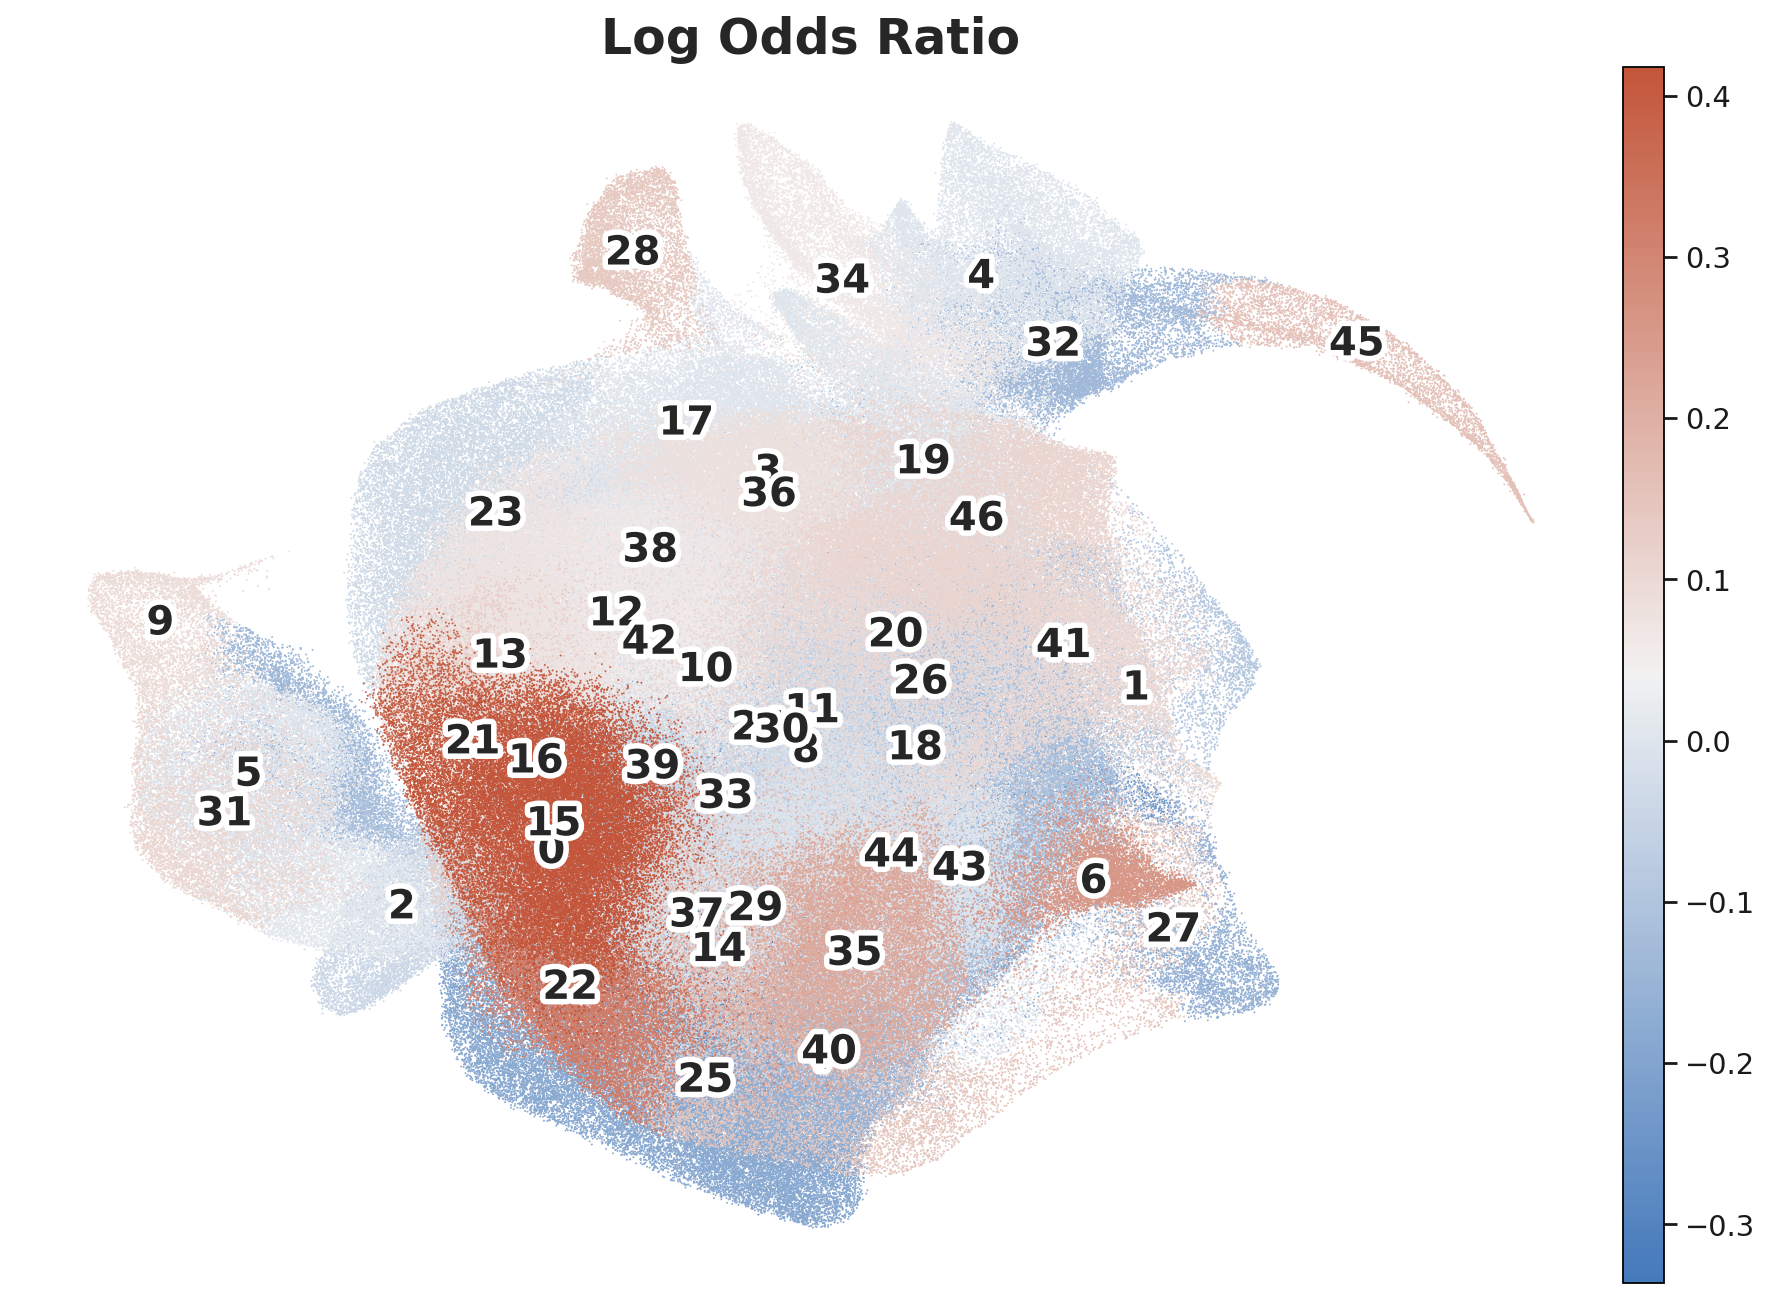

In [52]:


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111)
sc.set_figure_params(fontsize=13)
sc.pl.umap(adata_train, color='LogOR_Meso_type', show=False, size=3,  frameon=False, cmap=sns.diverging_palette(250, 20, as_cmap=True), ax=ax1);
# ax2 = fig.add_subplot(122)
sc.pl.umap(adata_train, color='leiden_2.0', show=False, size=3,  frameon=False, ax=ax1, legend_loc='on data', palette='tab20', alpha=0.0, legend_fontoutline = 5, legend_fontsize=18);
ax1.set_title('Log Odds Ratio', fontsize=22, weight='bold');

# ax2.set_title('Leiden Cluster Numbers', fontsize=20);
plt.savefig(os.path.join(figure_path, 'logreg_leiden.png'), dpi=300, bbox_inches='tight')

# sc.pl.umap(adata_train, color='P_value_Meso_type', show=False, size=3,  frameon=False, cmap=sns.diverging_palette(0, 0, center='dark',sep=1, l=90, as_cmap=True), legend_loc='on data');
# plt.savefig(os.path.join(figure_path, 'logreg_p_value.png'), dpi=500, bbox_inches='tight')

In [4]:
# Composition Dataframe.
type_composition = 'clr'
subtype_csvs_path = h5_complete_path.split('/hdf5_')[0] + '/{}/subtype_csvs'.format(meta_folder)			
data_df = pd.read_csv('{}/{}_{}_{}_fold{}.csv'.format(subtype_csvs_path, dataset, type_composition, groupby.replace('.', 'p'), fold_number), index_col=0)
additional_df = pd.read_csv('{}/{}_{}_{}_fold{}_additional.csv'.format(subtype_csvs_path, additional_dataset, type_composition, groupby.replace('.', 'p'), fold_number), index_col=0)

16 16


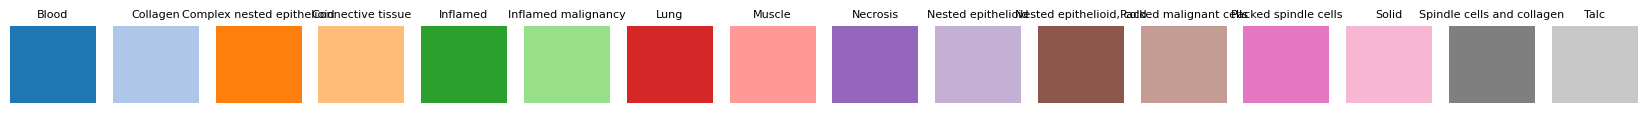

In [5]:
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
annotations['main_pattern'] = annotations['main_pattern'].apply(lambda x: str(x).capitalize() )
main_patterns = sorted(annotations['main_pattern'].unique().tolist())
colors = sns.color_palette('tab20', len(main_patterns))
color_map = annotations['main_pattern'].apply(lambda x: colors[main_patterns.index(x)]).tolist()
corr_data_main_pattern = pd.DataFrame({'Main Pattern': color_map}, index=annotations['HPC'].astype(str).values)
# display color and main pattern with plt
fig, ax = plt.subplots(1,len(main_patterns), figsize=(len(main_patterns)+5,1))
print(len(main_patterns), len(colors))
for i in range(0,len(main_patterns)):
    color = colors[i]
    label = main_patterns[i]
    ax[i].imshow(np.array(color).reshape(1,1,3))
    ax[i].set_title(label, fontsize=8)
    ax[i].axis('off')
    ax[i].set_aspect('auto')
plt.show()

from matplotlib.patches import Patch
lut = dict(zip(main_patterns, colors))
handles = [Patch(facecolor=lut[name]) for name in lut]

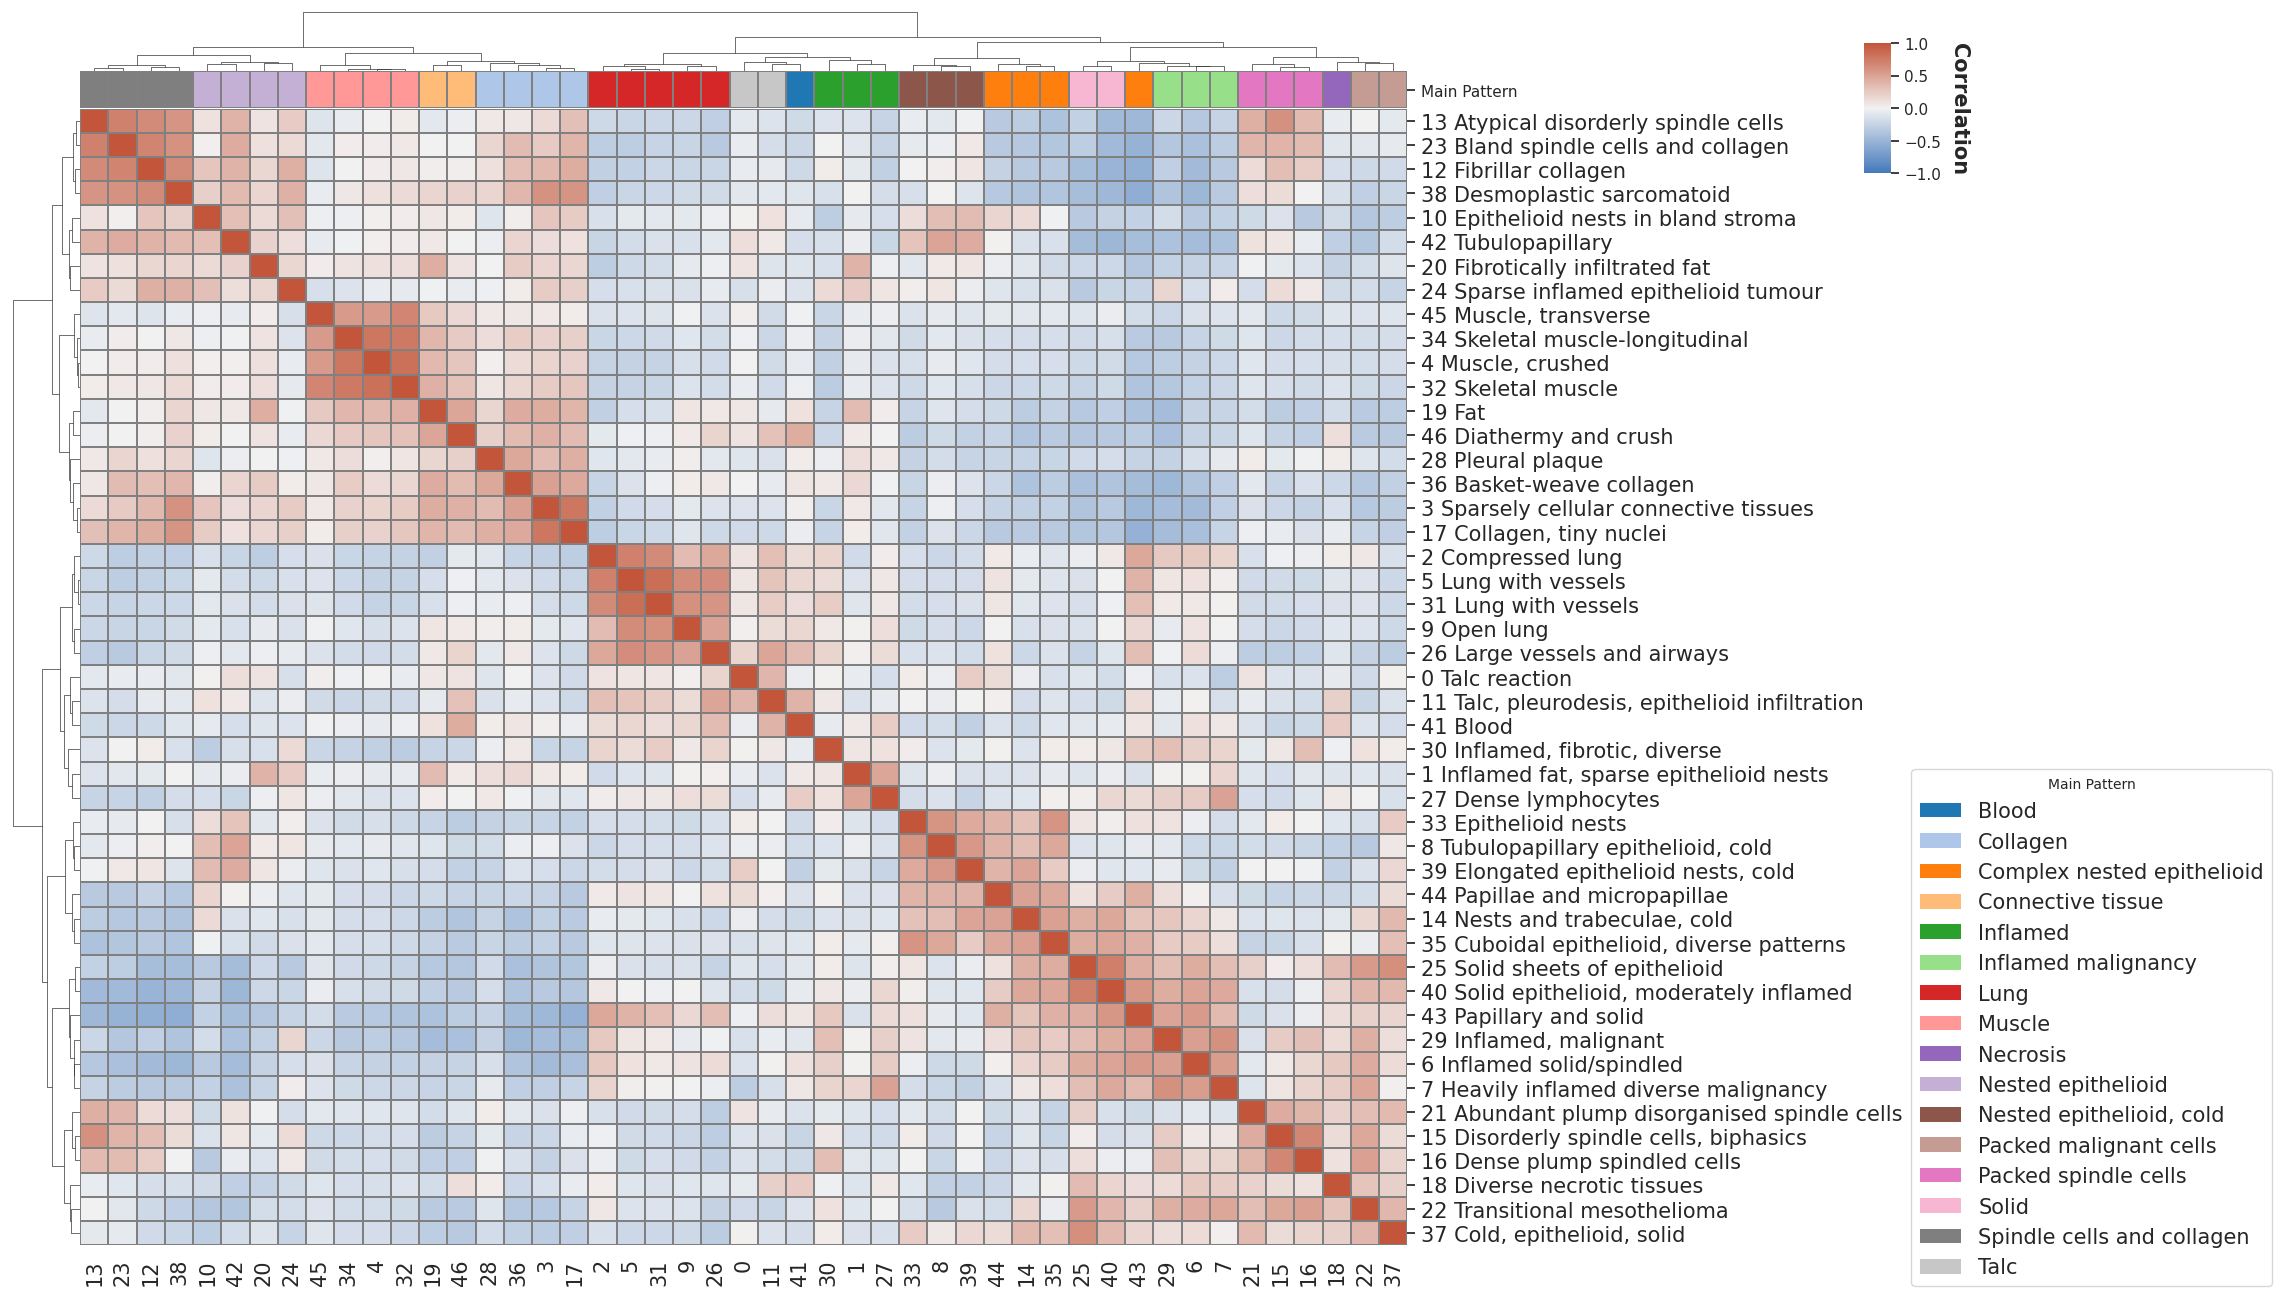

In [32]:
annot_flag = True
leiden_clusters = [str(x) for x in data_df.columns.tolist() if x.isdigit()]
corr_data = data_df[leiden_clusters].corr()

if annot_flag: annotation_text = ' ' + annotations['Summary'].values + ''
else: annotation_text = ''
corr_data.index = corr_data.index + annotation_text
sns.set(font_scale=1, style='white')




ax = sns.clustermap(corr_data, fmt='.1f', annot_kws={"size": 15}, vmin=-1, vmax=1, yticklabels=True,  xticklabels=True,  linecolor='gray', cmap=sns.diverging_palette(250, 20, as_cmap=True), figsize=(18,13), dendrogram_ratio=(0.05, 0.05), annot=False, method='ward', metric='euclidean', cbar_pos=(1.04, .86, 0.015, .1), linewidths=0.1, col_colors=corr_data_main_pattern)
ax.ax_cbar.set_ylabel('Correlation', fontsize=15, fontweight='bold', rotation=270, labelpad=20)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0, fontsize=15)

ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), rotation=90, fontsize=15)
plt.legend(handles, lut, title='Main Pattern', fontsize=15, title_fontsize=10, bbox_to_anchor=(15.5, -4.5))
plt.savefig(os.path.join(figure_path, 'cluster_corr.png'), dpi=200, bbox_inches='tight')

In [8]:
# For TCGA_MESO
leiden_clusters = [str(x) for x in additional_df.columns.tolist() if x.isdigit()]
corr_data = additional_df[leiden_clusters].corr()

if annot_flag: annotation_text = ' (' + annotations['Summary'].values + ')'
else: annotation_text = ''
corr_data.index = corr_data.index + annotation_text
sns.set(font_scale=1, style='white')




ax = sns.clustermap(corr_data, fmt='.1f', annot_kws={"size": 10}, vmin=-1, vmax=1, yticklabels=True,  xticklabels=True,  linecolor='gray', cmap=sns.diverging_palette(250, 20, as_cmap=True), figsize=(18,13), dendrogram_ratio=(0.15, 0.15), annot=False, method='ward', metric='euclidean', cbar_pos=(1.03, .86, 0.015, .1), linewidths=0.2, col_colors=corr_data_main_pattern)
ax.ax_cbar.set_ylabel('Pearson Correlation', fontsize=10, fontweight='bold', rotation=270, labelpad=20)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10, fontweight='bold')

ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), rotation=90, fontsize=10, fontweight='bold')
plt.legend(handles, lut, title='Main Pattern', fontsize=10, title_fontsize=10, bbox_to_anchor=(7.5, -5))
plt.savefig(os.path.join(figure_path, 'cluster_corr_tcga.png'), dpi=500, bbox_inches='tight')

### Density Plot for each HPC

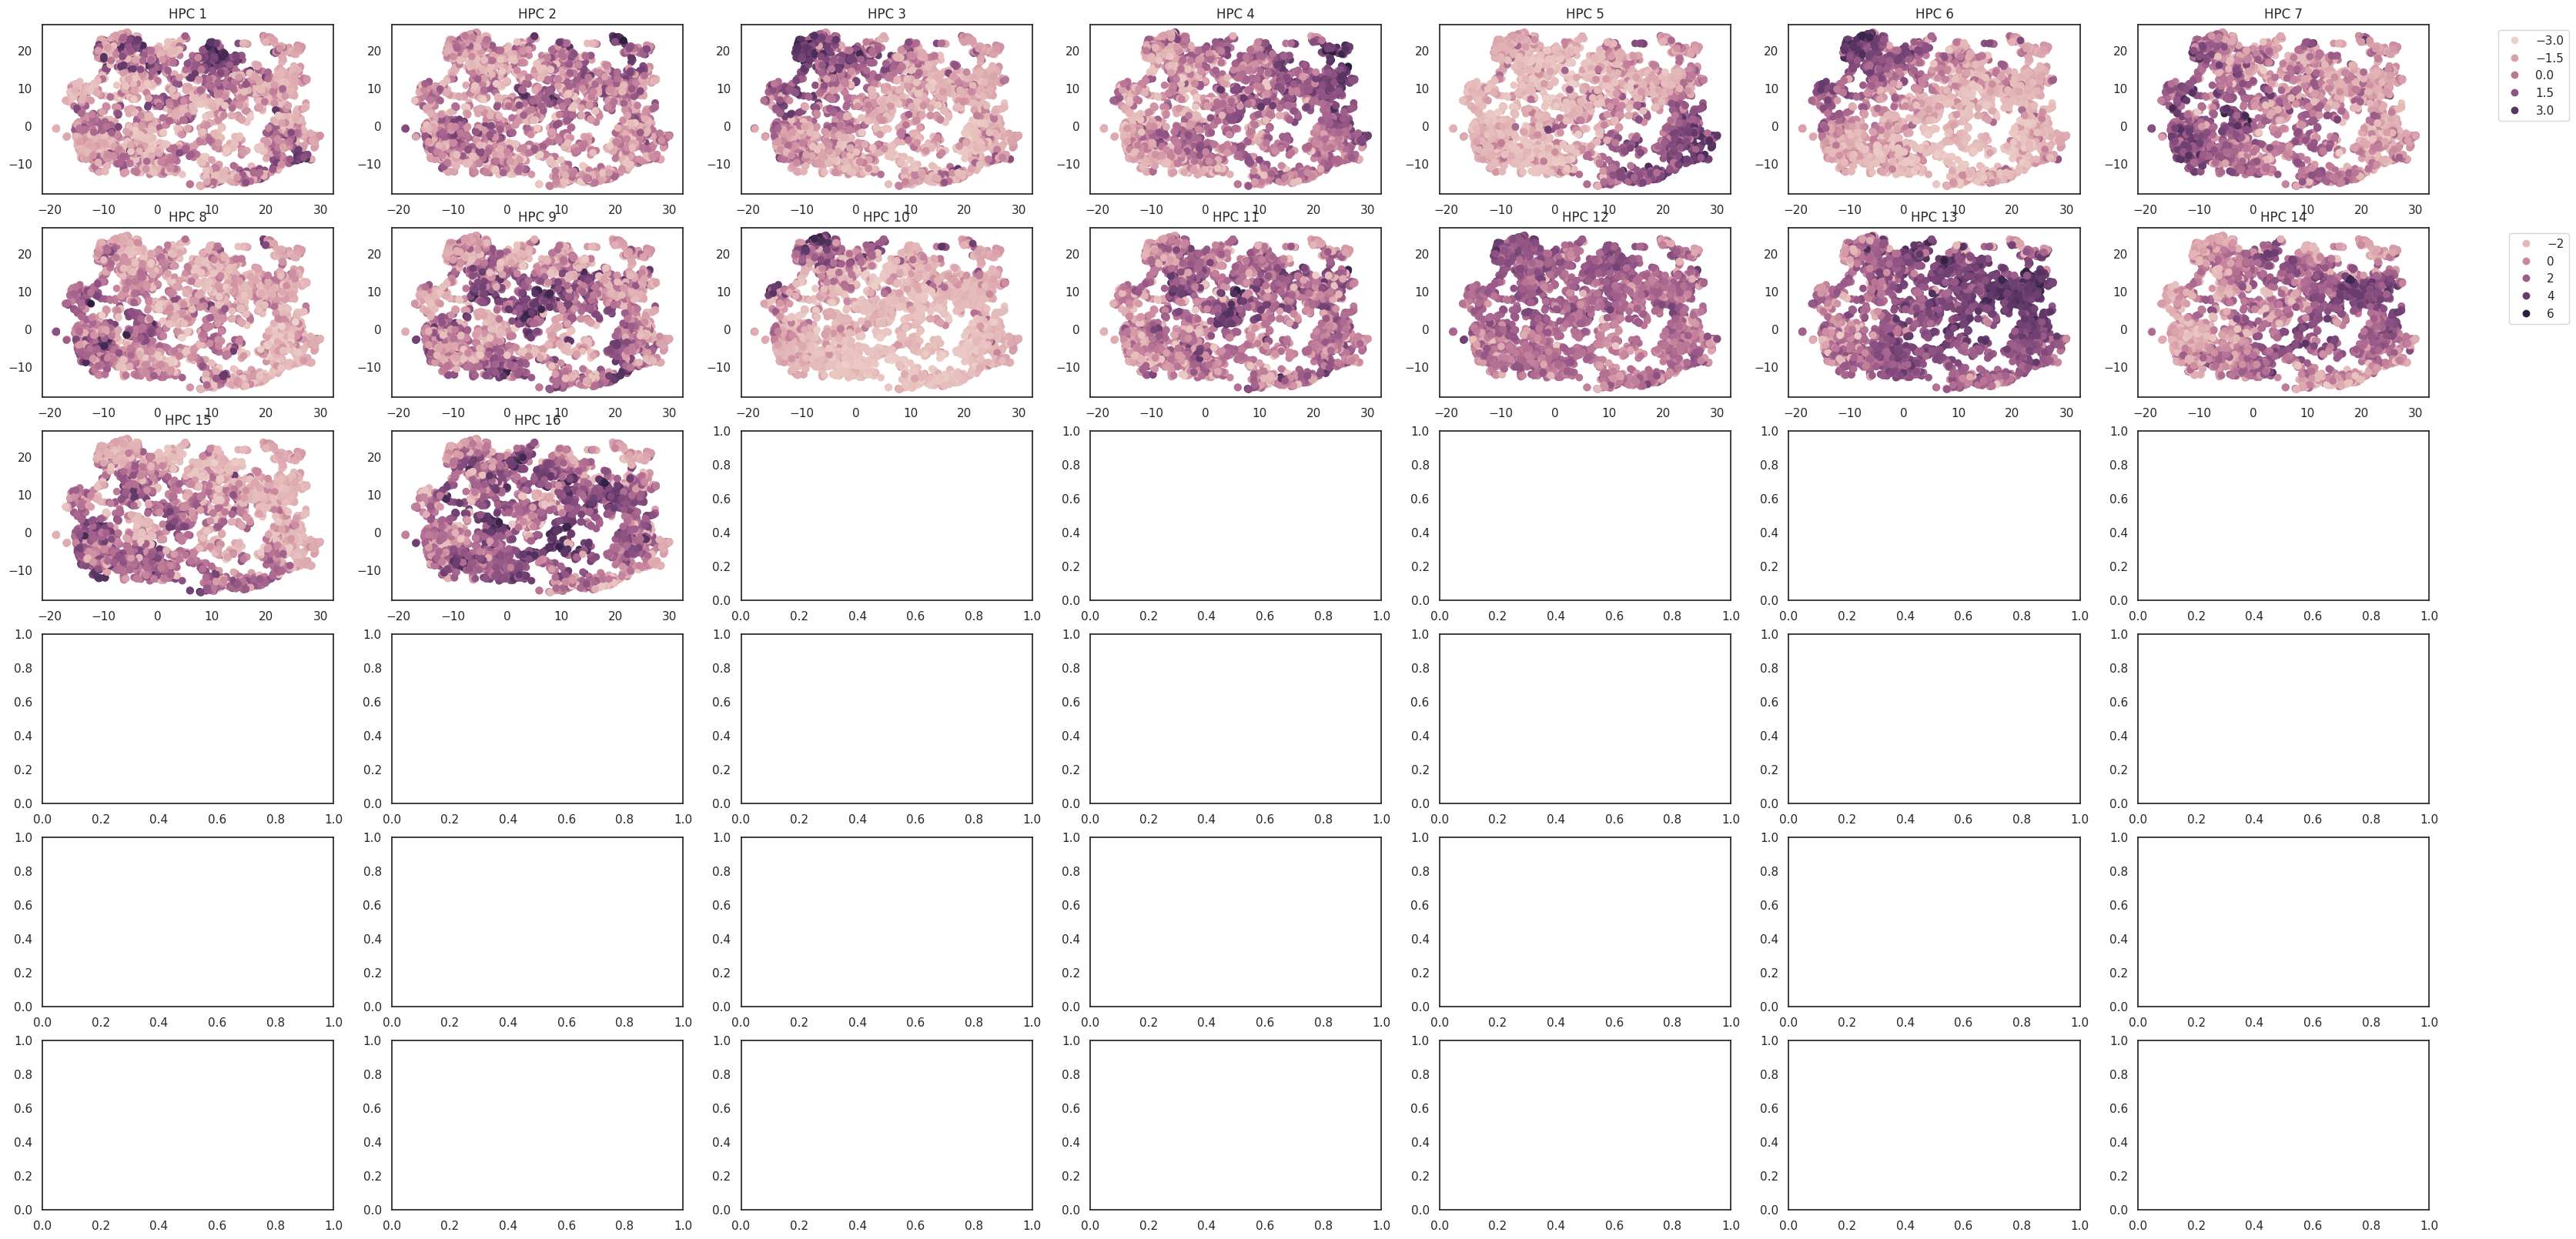

In [ ]:
fig, ax = plt.subplots(7,7,figsize=(40, 20))
ax = ax.ravel()
temp = data_df[leiden_clusters]
for i in range(1,len(leiden_clusters)+1):
    reducer = umap.UMAP(random_state=42, metric='correlation' , n_neighbors=5, min_dist=0.01, spread=5, verbose=False, n_components=2)
    embedding = reducer.fit_transform(temp)
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=temp.iloc[:,i-1] , s=50, alpha=1.0, edgecolors='none', ax=ax[i-1])
    ax[i-1].set_title('HPC {}'.format(i))
    ax[i-1].legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), ncol=1)

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'hpc_freq_umap.png'), dpi=300, bbox_inches='tight')

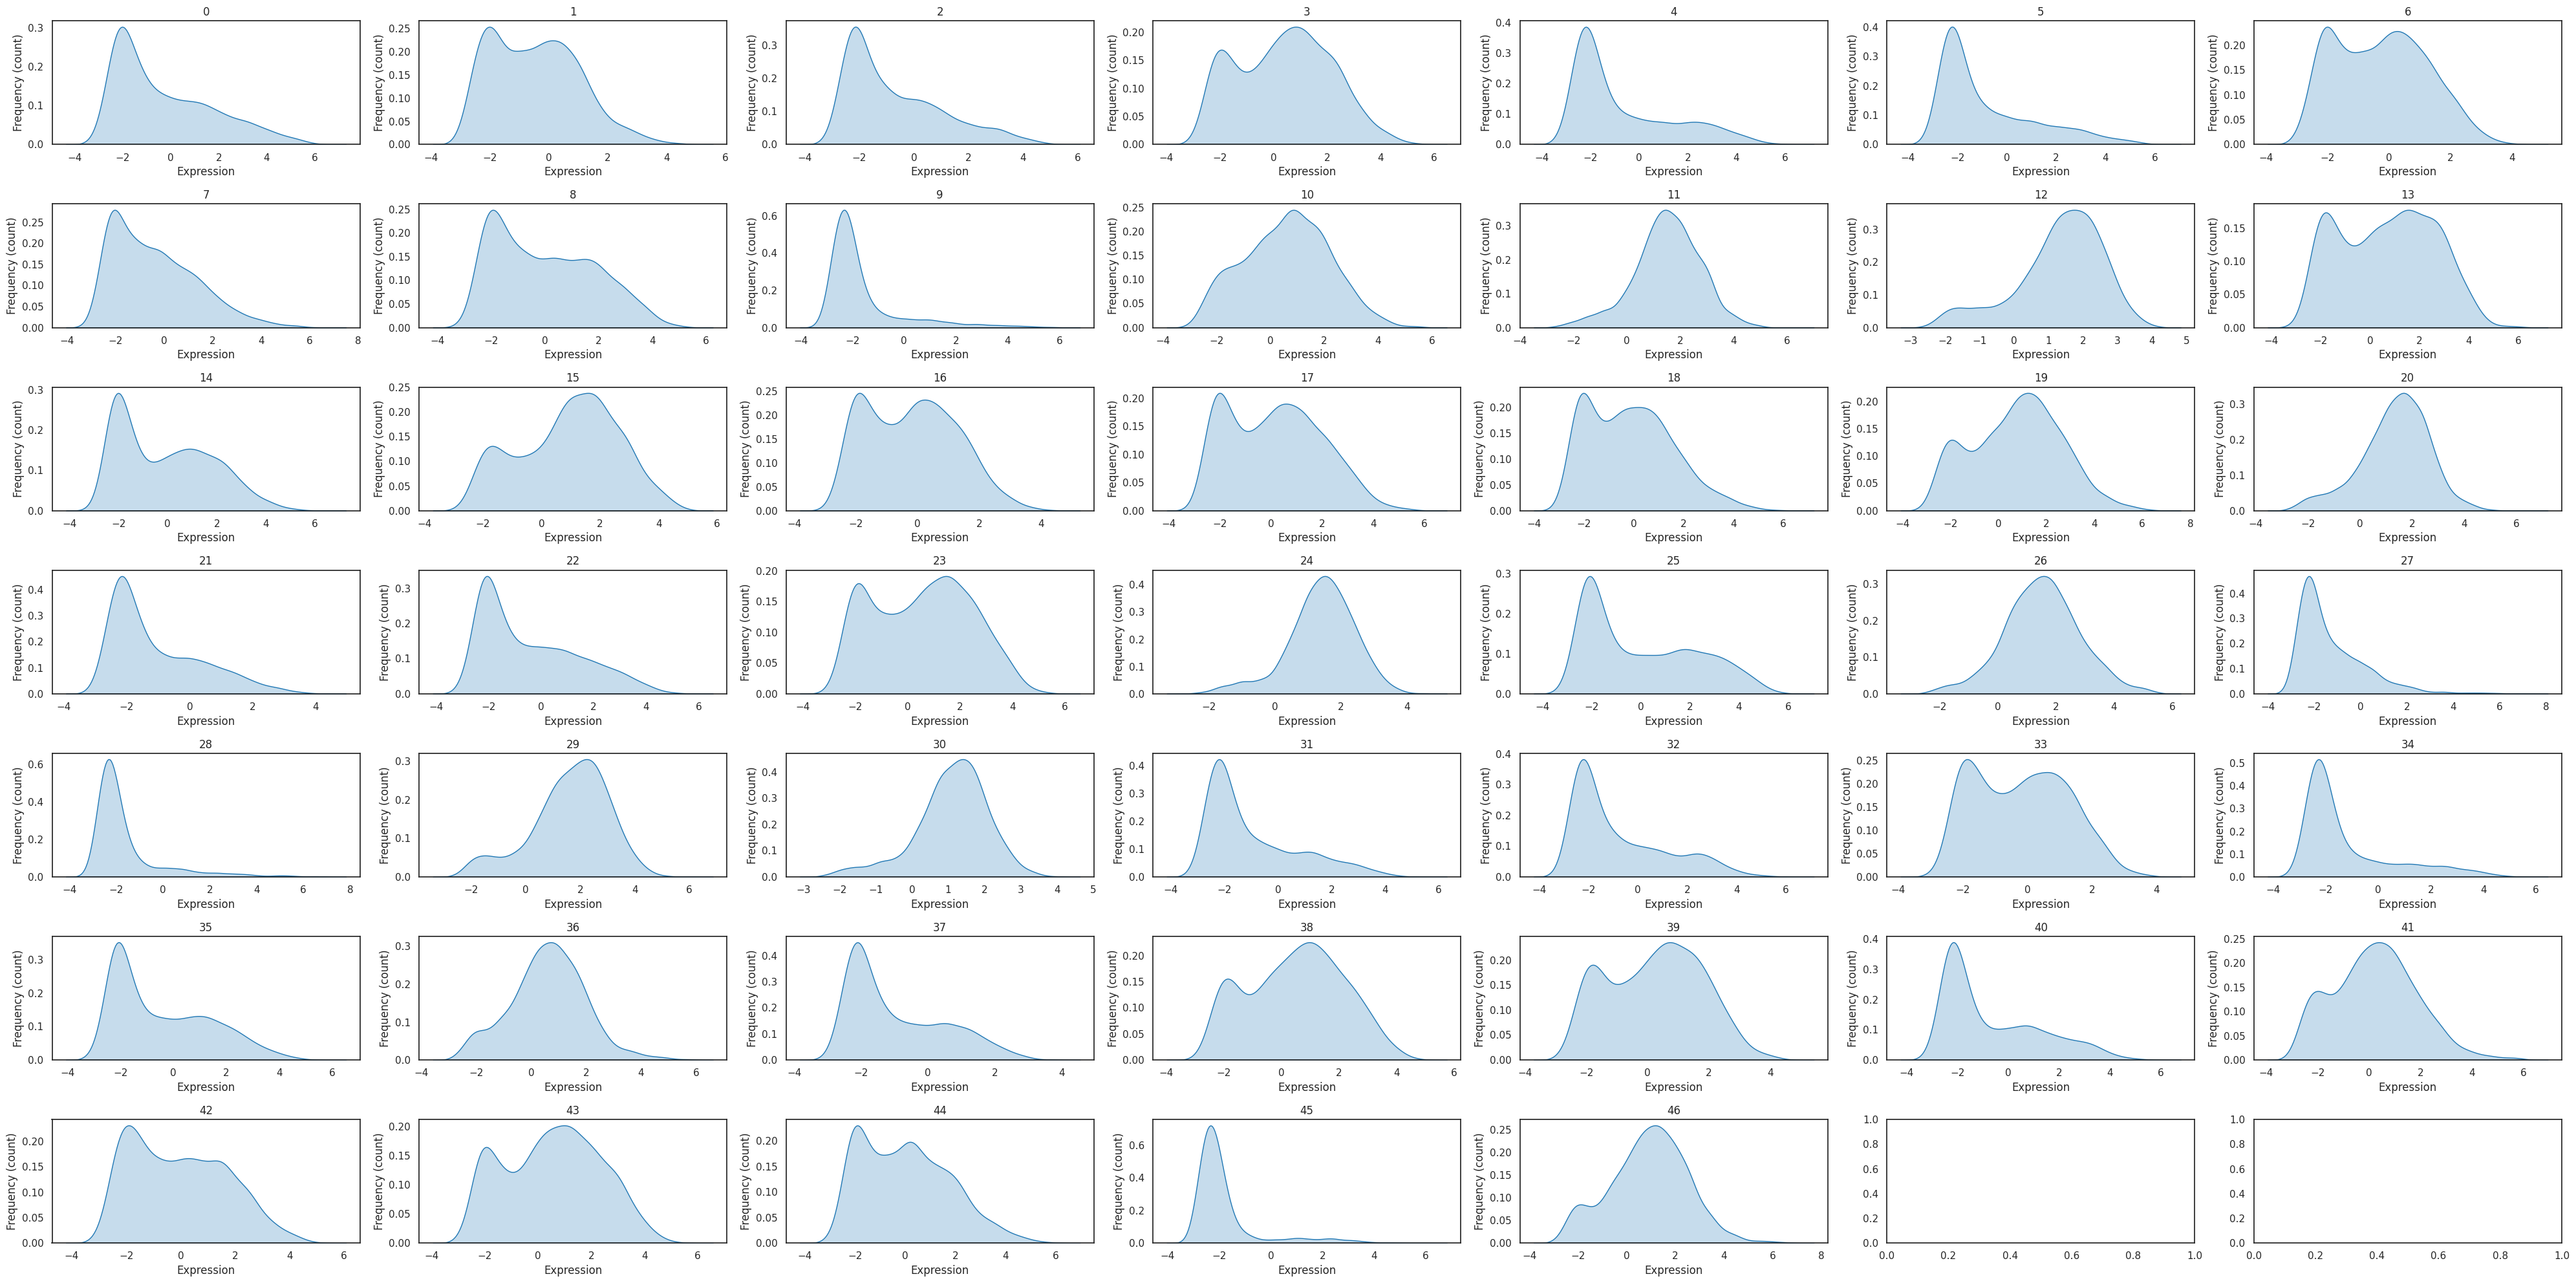

In [ ]:
fig, ax = plt.subplots(7,7,figsize=(40, 20))
ax = ax.ravel()
for i in range(1,len(leiden_clusters)+1):
    sns.kdeplot(data_df.iloc[:,i], ax=ax[i-1], shade=True, color='tab:blue')
    ax[i-1].set_title(data_df.columns[i])
    ax[i-1].set_ylabel('Frequency (count)')
    ax[i-1].set_xlabel('Expression')
plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'hpc_freq_kde.png'), dpi=300, bbox_inches='tight')

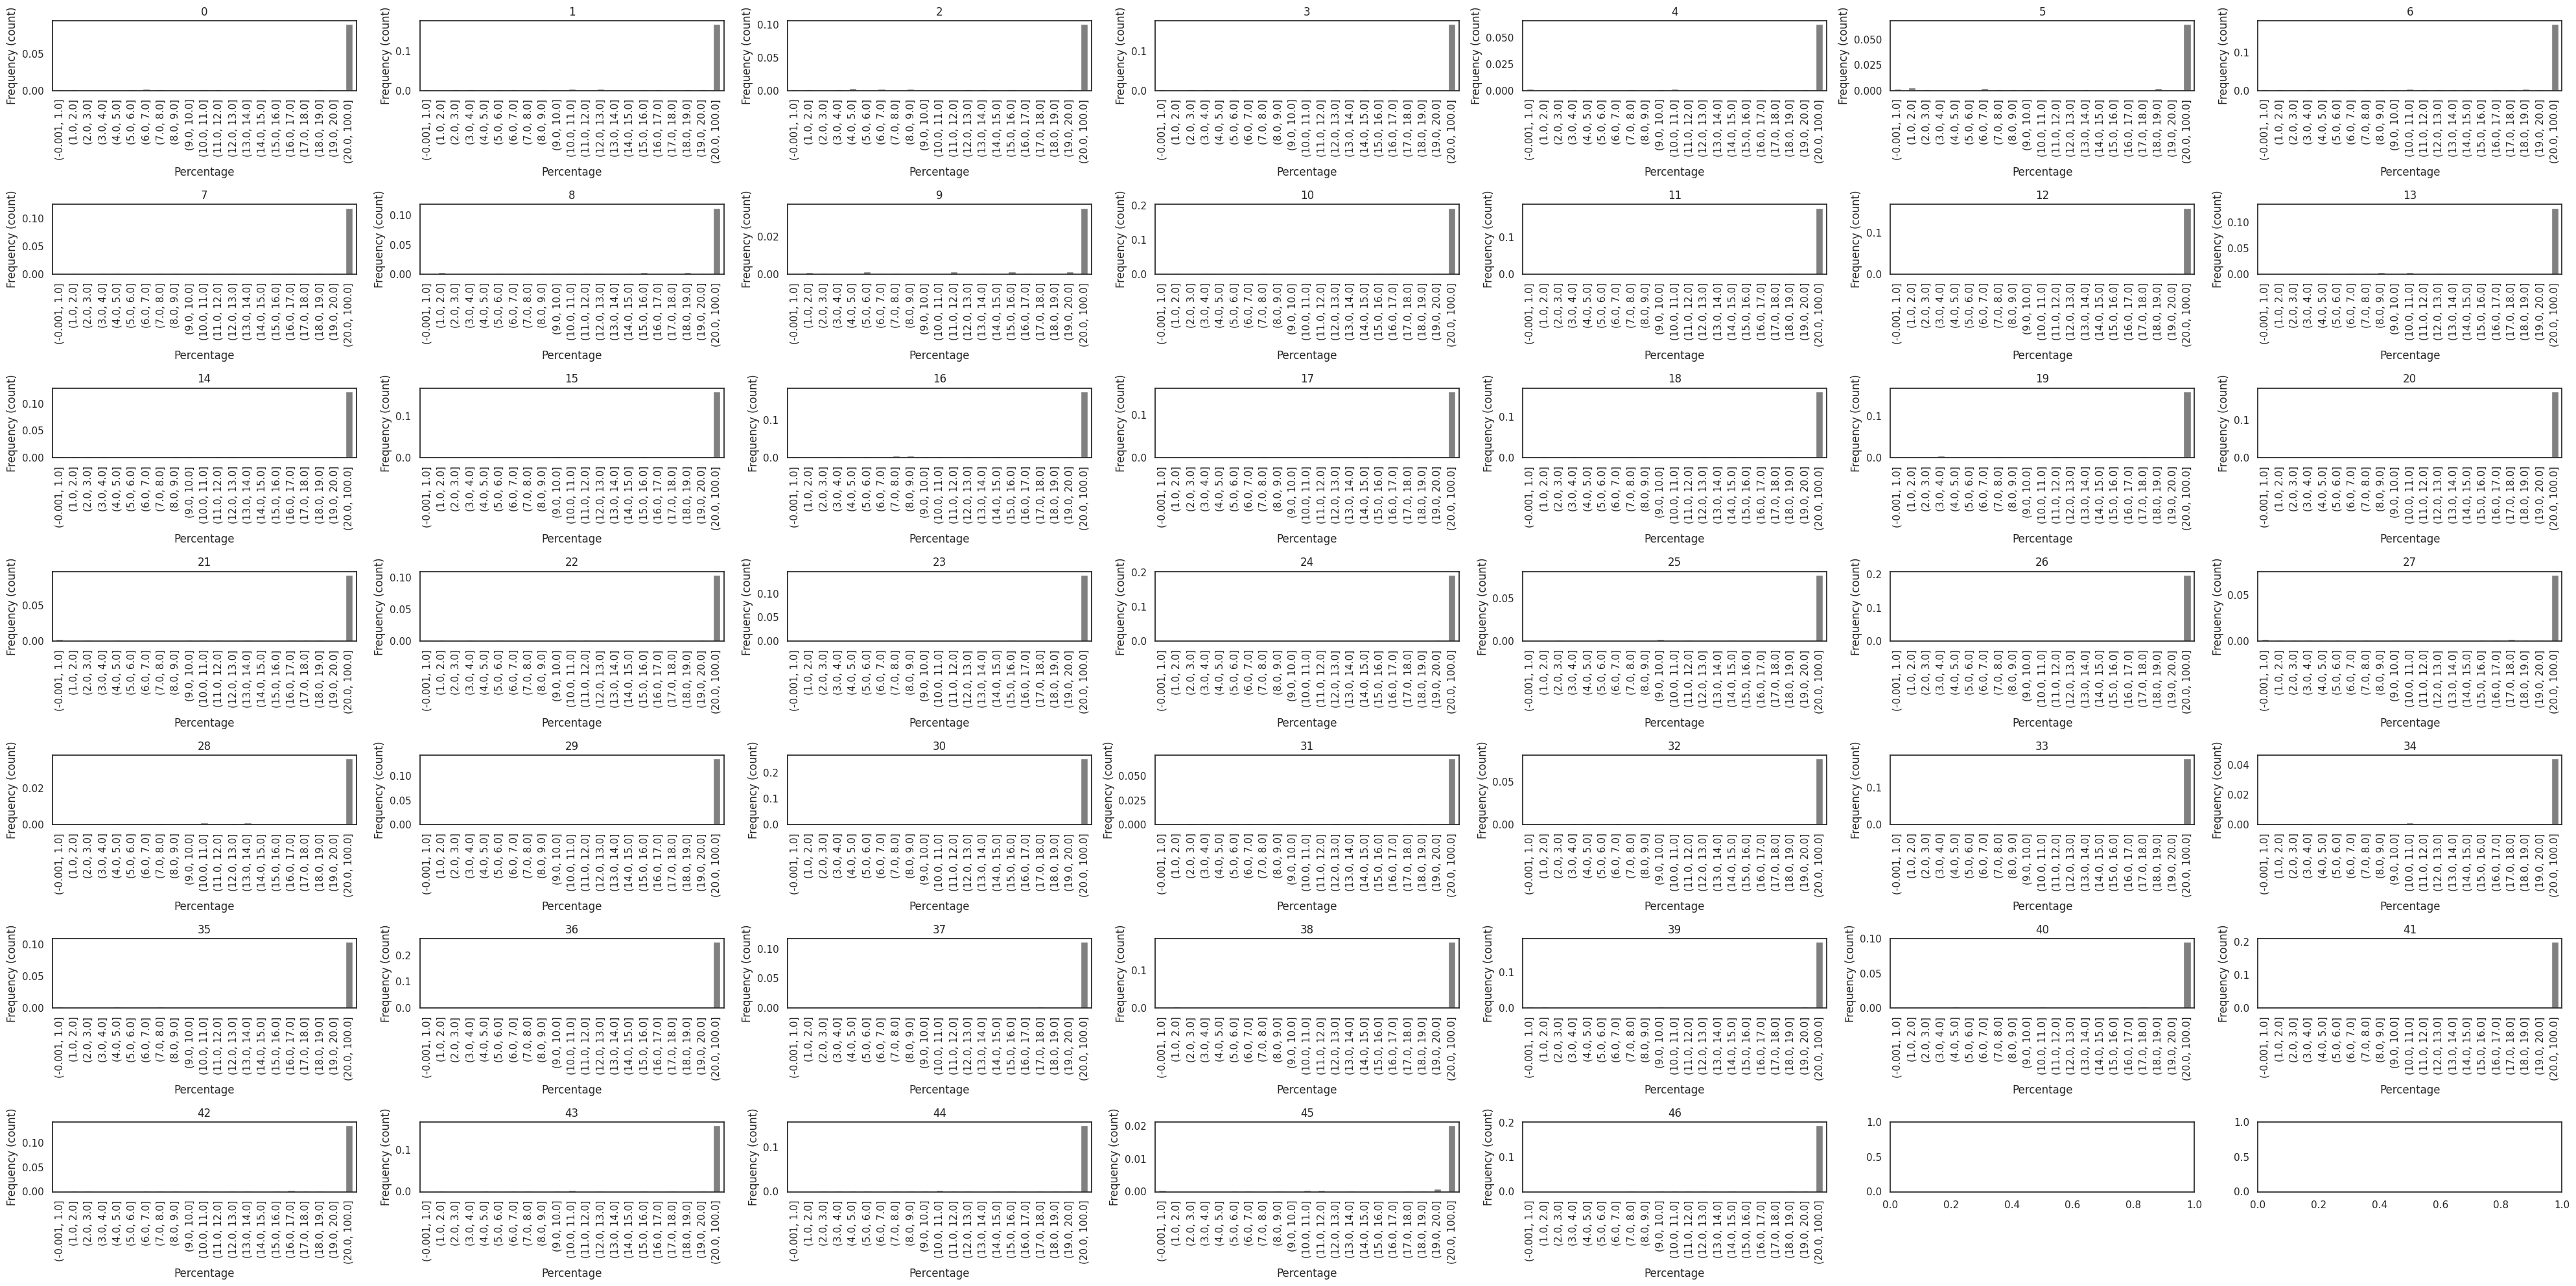

In [ ]:
fig, ax = plt.subplots(7,7,figsize=(40, 20))
ax = ax.ravel()
for i in range(1, len(leiden_clusters)+1):
    temp = data_df.iloc[:,i]*100
    temp.value_counts(sort=False, normalize=True, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,100]).plot(kind='bar', ax=ax[i-1], legend=False, color='grey')
    ax[i-1].set_title(data_df.columns[i])
    ax[i-1].set_xlabel('Percentage')
    ax[i-1].set_ylabel('Frequency (count)')
    

plt.tight_layout()
plt.savefig(os.path.join(alpha_path, 'hpc_freq_bar.png'), dpi=300, bbox_inches='tight')